# CIFAR-10 CNN Classification
Minimal CNN implementation targeting >70% accuracy on CIFAR-10 dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
# If you want to download CIFAR-10 dataset, use this cell
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [2]:
# If you've already downloaded CIFAR-10, run this cell instead
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
# Minimal CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
# Setup model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model parameters: 1,193,642


In [5]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

In [7]:
# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

In [8]:
# Training loop
epochs = 15
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_cifar10_cnn.pth')
    
    print(f'Epoch {epoch+1:2d}: Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, '
          f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

print(f'\nBest Test Accuracy: {best_acc:.2f}%')

Epoch  1: Train Loss: 1.195, Train Acc: 57.20%, Test Loss: 0.986, Test Acc: 65.40%
Epoch  2: Train Loss: 1.013, Train Acc: 64.12%, Test Loss: 0.838, Test Acc: 70.44%
Epoch  3: Train Loss: 0.896, Train Acc: 68.42%, Test Loss: 0.776, Test Acc: 73.15%
Epoch  4: Train Loss: 0.822, Train Acc: 71.18%, Test Loss: 0.724, Test Acc: 74.98%
Epoch  5: Train Loss: 0.764, Train Acc: 73.42%, Test Loss: 0.661, Test Acc: 77.71%
Epoch  6: Train Loss: 0.728, Train Acc: 74.42%, Test Loss: 0.633, Test Acc: 78.74%
Epoch  7: Train Loss: 0.699, Train Acc: 75.77%, Test Loss: 0.627, Test Acc: 78.27%
Epoch  8: Train Loss: 0.669, Train Acc: 76.65%, Test Loss: 0.606, Test Acc: 79.03%
Epoch  9: Train Loss: 0.645, Train Acc: 77.49%, Test Loss: 0.562, Test Acc: 80.32%
Epoch 10: Train Loss: 0.631, Train Acc: 78.15%, Test Loss: 0.584, Test Acc: 79.90%
Epoch 11: Train Loss: 0.613, Train Acc: 78.85%, Test Loss: 0.551, Test Acc: 81.60%
Epoch 12: Train Loss: 0.596, Train Acc: 79.34%, Test Loss: 0.550, Test Acc: 81.53%
Epoc

In [9]:
# Final evaluation
model.load_state_dict(torch.load('best_cifar10_cnn.pth'))
final_loss, final_acc = evaluate(model, test_loader, criterion, device)
print(f'Final Test Accuracy: {final_acc:.2f}%')

if final_acc > 70:
    print("✅ Target achieved: >70% accuracy!")
else:
    print("❌ Target not reached. Consider training longer or adjusting hyperparameters.")

Final Test Accuracy: 82.08%
✅ Target achieved: >70% accuracy!


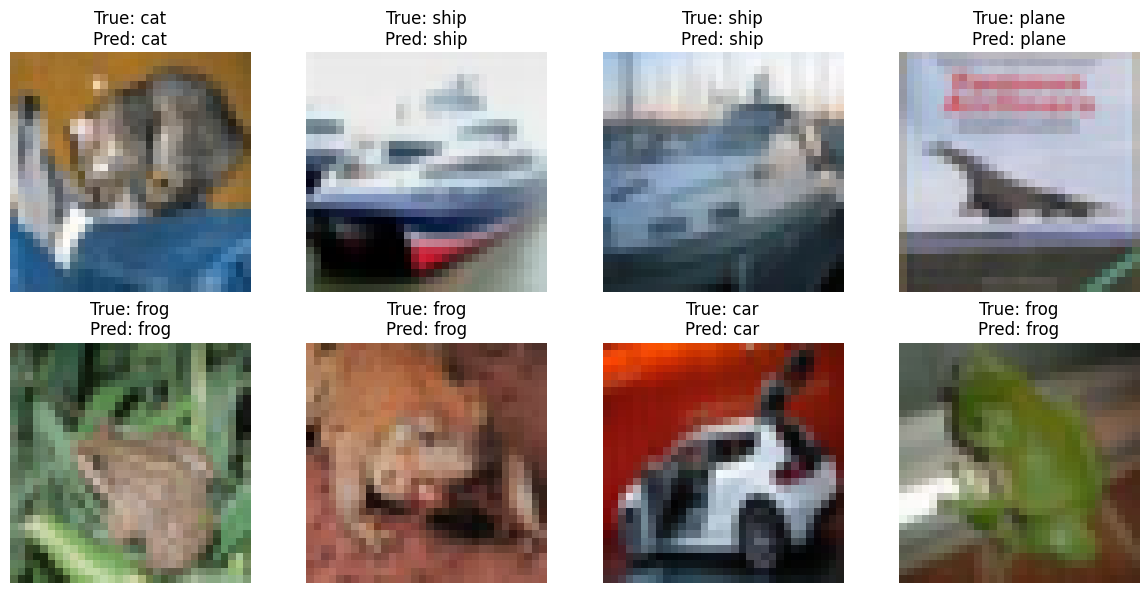

In [10]:
# Prediction example with best model
import matplotlib.pyplot as plt
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Show first 8 images with predictions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    ax = axes[i//4, i%4]
    # Denormalize image
    img = images[i] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()